In [ ]:
# Imports needed - Based on what I used for the other models
import torch.nn as nn
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import time
from threading import current_thread
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
data = np.load('/content/drive/MyDrive/Dissertation Dataset/plant_disease_data.npz')
X = data['images']
y = data['labels']

unique_labels = np.unique(y)
num_classes = len(unique_labels)

print("Unique labels:", unique_labels)
print("Number of classes:", num_classes)
print("Images Shape: ", X.shape)
print("Labels Shape: ", y.shape)

Unique labels: [0 1 2 3 4]
Number of classes: 5
Images Shape:  (20638, 256, 256, 3)
Labels Shape:  (20638,)


In [ ]:
# Get the training and testing images ready:
# Define split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.15  # 15% for validation
test_ratio = 0.15  # 15% for testing

# Step 1: Split into training and remaining data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42, stratify=y)

# Step 2: Split remaining data into validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, stratify=y_rem)

# Confirm split sizes
print("Training Set: ", X_train.shape, y_train.shape)
print("Validation Set: ", X_val.shape, y_val.shape)
print("Testing Set: ", X_test.shape, y_test.shape)

Training Set:  (14446, 256, 256, 3) (14446,)
Validation Set:  (3096, 256, 256, 3) (3096,)
Testing Set:  (3096, 256, 256, 3) (3096,)


In [ ]:
X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val = torch.tensor(y_val, dtype=torch.long)

In [ ]:
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Import CNN Architectures

In [ ]:
# My CNN model implementation
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Convolutional Layer 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 Kernel and a Stride of 2. Reduces to (16, 128, 128)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 Kernel and a Stride of 2. Reduces to (32, 64, 64)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten the tensor
        x = x.view(x.size(0), -1) # Flatten to (batch_size, 32 * 64 * 64)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# import the models
from torchvision.models import resnet50, vgg16

vgg_model = vgg16(pretrained=True)
num_classes = 5
vgg_model.classifier[6] = nn.Linear(in_features=vgg_model.classifier[6].in_features, out_features=5)

resnet_model = resnet50(pretrained=True)
num_classes = 5
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

cnn10_model = CNN()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 106MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

In [ ]:
# Load saved weights
vgg_model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation Dataset/vgg_model_20epoch.pth'))
resnet_model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation Dataset/resnet50_20epoch.pth'))
cnn10_model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation Dataset/cnn_10layer_arc.pth'))

<ipython-input-8-d3e452a37741>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation Dataset/vgg_model_2

<All keys matched successfully>

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Predictions
resnet_predictions = torch.empty((0, num_classes)).to(device)
vgg_predictions = torch.empty((0, num_classes)).to(device)
cnn10_predictions = torch.empty((0, num_classes)).to(device)

In [ ]:
# pass the images through the model
resnet_model.eval()
vgg_model.eval()
cnn10_model.eval()

resnet_model.to(device)
vgg_model.to(device)
cnn10_model.to(device)

resnet_allpreds = []
vgg_allpreds = []
cnn10_allpreds = []

with torch.no_grad():
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)

    resnet_output = resnet_model(images)
    vgg_output = vgg_model(images)
    cnn10_output = cnn10_model(images)

    probs_resnet = F.softmax(resnet_output, dim=1)
    probs_vgg = F.softmax(vgg_output, dim=1)
    probs_cnn10 = F.softmax(cnn10_output, dim=1)

    predictedLabel_resnet = torch.argmax(probs_resnet, dim=1)
    predictedLabel_vgg = torch.argmax(probs_vgg, dim=1)
    predictedLabel_cnn10 = torch.argmax(probs_cnn10, dim=1)

    # Store predictions and actual labels
    resnet_allpreds.extend(predictedLabel_resnet.cpu().numpy())
    vgg_allpreds.extend(predictedLabel_vgg.cpu().numpy())
    cnn10_allpreds.extend(predictedLabel_cnn10.cpu().numpy())

    resnet_predictions = torch.cat((resnet_predictions, probs_resnet), dim=0)
    vgg_predictions = torch.cat((vgg_predictions, probs_vgg), dim=0)
    cnn10_predictions = torch.cat((cnn10_predictions, probs_cnn10), dim=0)

  print(resnet_predictions.shape)
  print(vgg_predictions.shape)
  print(cnn10_predictions.shape)

  # print comparison
  for i in range(len(resnet_allpreds)):
    print(f"ResNet Prediction: {resnet_allpreds[i]}, VGG Prediction: {vgg_allpreds[i]}, CNN10 Prediction: {cnn10_allpreds[i]}, ACTUAL LABEL = {y_val[i]}")



torch.Size([3096, 5])
torch.Size([3096, 5])
torch.Size([3096, 5])
ResNet Prediction: 1, VGG Prediction: 1, CNN10 Prediction: 1, ACTUAL LABEL = 1
ResNet Prediction: 1, VGG Prediction: 1, CNN10 Prediction: 1, ACTUAL LABEL = 1
ResNet Prediction: 2, VGG Prediction: 2, CNN10 Prediction: 2, ACTUAL LABEL = 2
ResNet Prediction: 3, VGG Prediction: 3, CNN10 Prediction: 1, ACTUAL LABEL = 3
ResNet Prediction: 1, VGG Prediction: 1, CNN10 Prediction: 1, ACTUAL LABEL = 1
ResNet Prediction: 3, VGG Prediction: 3, CNN10 Prediction: 3, ACTUAL LABEL = 3
ResNet Prediction: 3, VGG Prediction: 3, CNN10 Prediction: 1, ACTUAL LABEL = 1
ResNet Prediction: 0, VGG Prediction: 0, CNN10 Prediction: 0, ACTUAL LABEL = 0
ResNet Prediction: 4, VGG Prediction: 4, CNN10 Prediction: 4, ACTUAL LABEL = 4
ResNet Prediction: 0, VGG Prediction: 0, CNN10 Prediction: 0, ACTUAL LABEL = 0
ResNet Prediction: 2, VGG Prediction: 2, CNN10 Prediction: 2, ACTUAL LABEL = 2
ResNet Prediction: 3, VGG Prediction: 3, CNN10 Prediction: 3, ACT

In [ ]:
from sklearn.metrics import accuracy_score
accuracyRes = accuracy_score(resnet_allpreds, y_val)
print(f"Accuracy RESNET-50: {accuracyRes:.4f}")

accuracyVGG = accuracy_score(vgg_allpreds, y_val)
print(f"Accuracy VGG16: {accuracyVGG:.4f}")

accuracyCNN = accuracy_score(cnn10_allpreds, y_val)
print(f"Accuracy CNN10: {accuracyCNN:.4f}")



Accuracy RESNET-50: 0.9803
Accuracy VGG16: 0.9461
Accuracy CNN10: 0.9696


In [ ]:
from sklearn.metrics import f1_score
f1Res = f1_score(y_val, resnet_allpreds, average='weighted')
print(f"F1 Score RESNET-50: {f1Res:.4f}")

f1VGG = f1_score(vgg_allpreds, y_val, average='weighted')
print(f"F1 Score VGG16: {f1VGG:.4f}")

f1CNN = f1_score(cnn10_allpreds, y_val, average='weighted')
print(f"F1 Score CNN10: {f1CNN:.4f}")

F1 Score RESNET-50: 0.9803
F1 Score VGG16: 0.9457
F1 Score CNN10: 0.9697


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix_resnet = confusion_matrix(y_val, resnet_allpreds)
confusion_matrix_vgg = confusion_matrix(y_val, vgg_allpreds)
confusion_matrix_cnn10 = confusion_matrix(y_val, cnn10_allpreds)

print("Confusion Matrix RESNET-50:")
print(confusion_matrix_resnet)

print("\nConfusion Matrix VGG16:")
print(confusion_matrix_vgg)

print("\nConfusion Matrix CNN10:")
print(confusion_matrix_cnn10)

Confusion Matrix RESNET-50:
[[ 482    0    0    1    0]
 [  10 1320    1   24    1]
 [   0    3  530    1    3]
 [   2    2    0  465    0]
 [   3    9    1    0  238]]

Confusion Matrix VGG16:
[[ 462   10    1    9    1]
 [   2 1259   16   60   19]
 [   0   14  515    3    5]
 [   0    6    1  462    0]
 [   0   10    9    1  231]]

Confusion Matrix CNN10:
[[ 472   11    0    0    0]
 [   5 1329    8    5    9]
 [   0    2  532    3    0]
 [   0   34    0  435    0]
 [   0   15    2    0  234]]


In [ ]:
# Count the y_val. Amount per class
unique_labels, counts = np.unique(y_val, return_counts=True)
print(dict(zip(unique_labels, counts)))

{0: 483, 1: 1356, 2: 537, 3: 469, 4: 251}


In [ ]:
from sklearn.metrics import precision_score, recall_score

prec_res = precision_score(y_val, resnet_allpreds, average='weighted')
rec_res = recall_score(y_val, resnet_allpreds, average='weighted')

print(f"Precision RESNET-50: {prec_res:.4f}")
print(f"Recall RESNET-50: {rec_res:.4f}")
print("======")
prec_vgg = precision_score(y_val, vgg_allpreds, average='weighted')
rec_vgg = recall_score(y_val, vgg_allpreds, average='weighted')

print(f"Precision VGG16: {prec_vgg:.4f}")
print(f"Recall VGG16: {rec_vgg:.4f}")
print("======")
prec_cnn10 = precision_score(y_val, cnn10_allpreds, average='weighted')
rec_cnn10 = recall_score(y_val, cnn10_allpreds, average='weighted')

print(f"Precision CNN10: {prec_cnn10:.4f}")
print(f"Recall CNN10: {rec_cnn10:.4f}")
print("======")

Precision RESNET-50: 0.9807
Recall RESNET-50: 0.9803
Precision VGG16: 0.9486
Recall VGG16: 0.9461
Precision CNN10: 0.9699
Recall CNN10: 0.9696


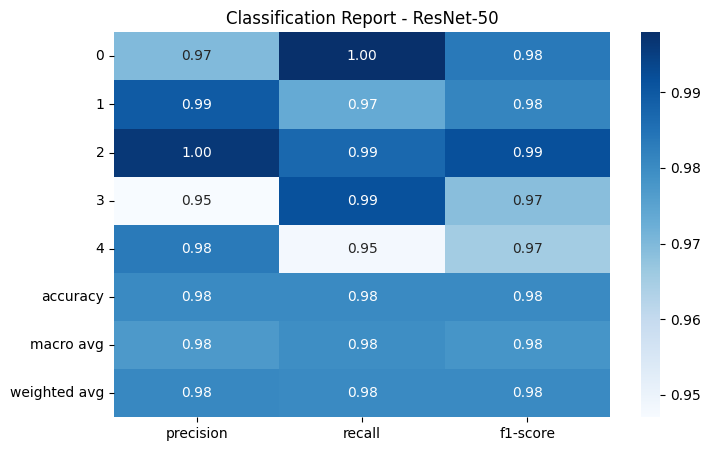

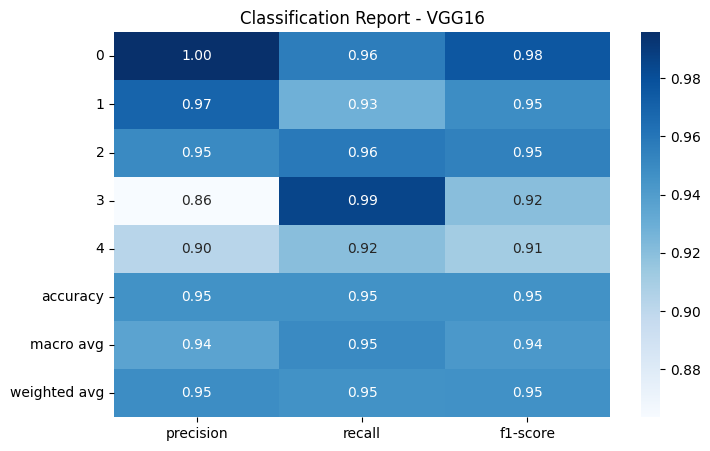

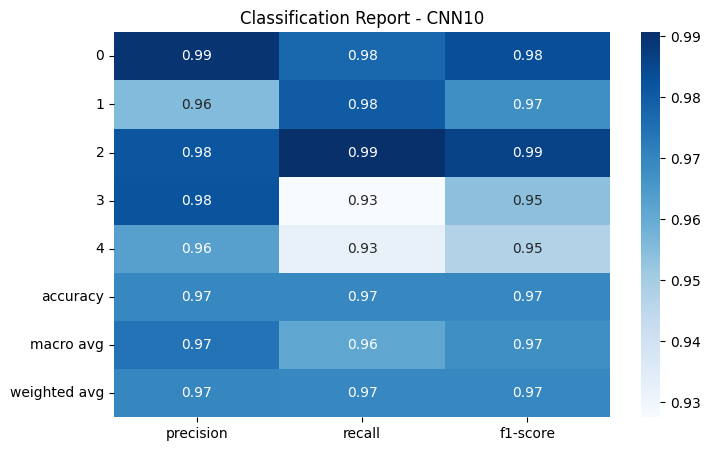

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

def plot_classification_report(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'accuracy' row
    plt.figure(figsize=(8,5))
    sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f")
    plt.title(f"Classification Report - {model_name}")
    plt.show()

plot_classification_report(y_val, resnet_allpreds, "ResNet-50")
plot_classification_report(y_val, vgg_allpreds, "VGG16")
plot_classification_report(y_val, cnn10_allpreds, "CNN10")


In [ ]:
# put this in a heatmap
lkfsnvljn


